In [1]:
!pip install tqdm

In [2]:
!wget https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/hand.npy


Redirecting output to ‘wget-log’.


In [0]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
import pickle as pkl

import time

In [0]:
data =  np.load('hand.npy')

In [28]:
data.shape

(291773, 784)

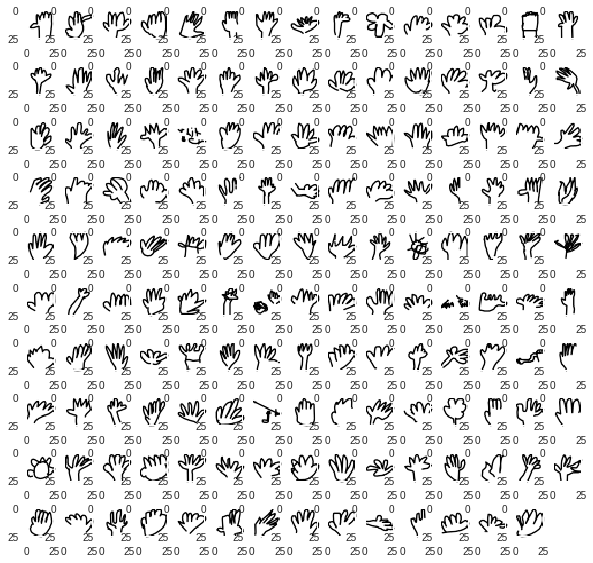

In [6]:
fig=plt.figure(figsize=(10, 10))
columns = 15
rows = 10
for i in range(1, columns*rows):
    img = data[i+44].reshape((28,28))
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

In [0]:
def model_inputs(real_dims, z_dims):
  inputs_real = tf.placeholder(tf.float32, shape=(None, real_dims), name='input_real')
  inputs_z = tf.placeholder(tf.float32, shape=(None, z_dims), name='input_z')
  
  return inputs_real, inputs_z

In [0]:
from tqdm import trange
def get_data(path):
        try:
            data = np.load(path)

            Y = []
            for i in trange(data.shape[0]):
                Y.append([1,0])
            Y = np.array(Y)

            (x_train, y_train, x_test, y_test) = train_test_split(data, Y)
            x_train = (x_train.astype(np.float32)) / 255
            x_train = x_train.reshape(x_train.shape[0], 784)

            return (x_train, y_train, x_test, y_test)  

        except Exception as e:
            print (e)            

In [10]:
x_train, y_train, x_test, y_test = get_data('hand.npy')

100%|██████████| 291773/291773 [00:00<00:00, 395182.40it/s]


In [11]:
x_train.shape

(218829, 784)

In [0]:

def generator(z, out_dims, n_units=128, reuse=False, alpha=0.01):
  with tf.variable_scope('generator', reuse=reuse):
    
    #hidden layer
    h1 = tf.layers.dense(z,n_units, activation=None,)
    
    #leaky relu implementation
    h1 = tf.maximum(alpha*h1, h1)
    
    #tanh 
    logits = tf.layers.dense(h1, out_dims)
    
    out = tf.tanh(logits)
    
    return out

In [0]:
def discriminator(x, n_units=128, reuse=False, alpha=0.01):
  with tf.variable_scope('discriminator', reuse=reuse):
    
    #hidden layer
    h1 = tf.layers.dense(x, n_units, activation=None)
    #leaky_relu
    h1 = tf.maximum(alpha*h1, h1)
    
    #sigmoid
    logits = tf.layers.dense(h1, 1, activation=None)
    out = tf.sigmoid(logits)
    
    return out, logits

In [0]:
#hyperparams

r_size = 784
z_size = 100
g_units = 128
d_units = 128

alpha = 0.01

smooth = 0.1

In [0]:

tf.reset_default_graph()

inputs_real, inputs_z = model_inputs(r_size, z_size)

In [0]:
g_out = generator(inputs_z, r_size, g_units)

In [0]:
d_out_real, real_logit = discriminator(inputs_real,)
d_out_fake, fake_logits = discriminator(g_out, reuse=True)

In [0]:
d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=real_logit, labels=tf.ones_like(real_logit)*(1-smooth)))

In [0]:
d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_logits, labels=tf.zeros_like(fake_logits)))

In [0]:
d_loss = d_loss_fake+d_loss_real

In [0]:
g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_logits, labels=tf.ones_like(fake_logits)))

In [0]:
lr = 0.002

In [0]:
tvar = tf.trainable_variables()

In [0]:
gvar = [var for var in tvar if var.name.startswith('generator')]

In [0]:
dvar = [var for var in tvar if var.name.startswith('discriminator')]

In [0]:
d_opt = tf.train.AdamOptimizer(learning_rate=lr).minimize(d_loss, var_list=dvar)
g_opt = tf.train.AdamOptimizer(lr).minimize(g_loss,var_list=gvar)

In [47]:
start = time.time()
batch_size = 100
epochs = 500
samples = []
losses = []
# Only save generator variables
saver = tf.train.Saver(var_list=gvar)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for e in range(epochs):
        for ii in range(x_train.shape[0]//batch_size):
            batch = x_train[np.random.randint(0, x_train.shape[0], size=batch_size)]
            
            batch_images = batch*2 - 1
            
            # Sample random noise for G
            batch_z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            
            # Run optimizers
            _ = sess.run(d_opt, feed_dict={inputs_real: batch_images, inputs_z: batch_z})
            _ = sess.run(g_opt, feed_dict={inputs_z: batch_z})
        
        # At the end of each epoch, get the losses and print them out
        train_loss_d = sess.run(d_loss, {inputs_z: batch_z, inputs_real: batch_images})
        train_loss_g = g_loss.eval({inputs_z: batch_z})
        if e%10 == 0:    
          print("Epoch {}/{}...".format(e, epochs),
                "Discriminator Loss: {:.4f}...".format(train_loss_d),
                "Generator Loss: {:.4f}".format(train_loss_g))    
        # Save losses to view after training
        losses.append((train_loss_d, train_loss_g))
        
        # Sample from generator as we're training for viewing afterwards
        sample_z = np.random.uniform(-1, 1, size=(16, z_size))
        gen_samples = sess.run(
                       generator(inputs_z, r_size, n_units=g_units, reuse=True, alpha=alpha),
                       feed_dict={inputs_z: sample_z})
        samples.append(gen_samples)
        saver.save(sess, './checkpoints/generator.ckpt')

# Save training generator samples
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)

end = time.time()
print('Time elapsed : ', (end-start)/60, ' mins.')

Epoch 0/500... Discriminator Loss: 1.6707... Generator Loss: 1.4493
Epoch 10/500... Discriminator Loss: 0.9074... Generator Loss: 2.4779
Epoch 20/500... Discriminator Loss: 1.1374... Generator Loss: 2.0511
Epoch 30/500... Discriminator Loss: 0.9474... Generator Loss: 1.7452
Epoch 40/500... Discriminator Loss: 0.8880... Generator Loss: 2.4058
Epoch 50/500... Discriminator Loss: 0.8076... Generator Loss: 1.9397
Epoch 60/500... Discriminator Loss: 1.1116... Generator Loss: 2.3747
Epoch 70/500... Discriminator Loss: 1.1073... Generator Loss: 1.9609
Epoch 80/500... Discriminator Loss: 0.6991... Generator Loss: 2.5973
Epoch 90/500... Discriminator Loss: 0.7232... Generator Loss: 2.5385
Epoch 100/500... Discriminator Loss: 0.9148... Generator Loss: 2.5839
Epoch 110/500... Discriminator Loss: 0.8684... Generator Loss: 2.0452
Epoch 120/500... Discriminator Loss: 0.8051... Generator Loss: 2.4832
Epoch 130/500... Discriminator Loss: 0.7279... Generator Loss: 2.3884
Epoch 140/500... Discriminator 

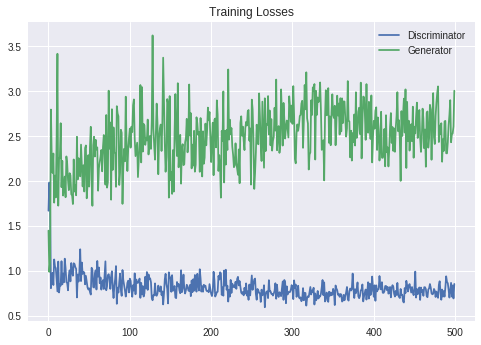

In [48]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()
plt.show()

In [0]:
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(5,5), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys')
    
    return fig, axes

In [0]:
# Load samples from generator taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

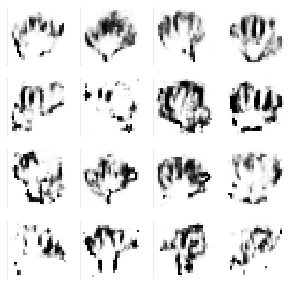

In [51]:
_ = view_samples(299, samples)

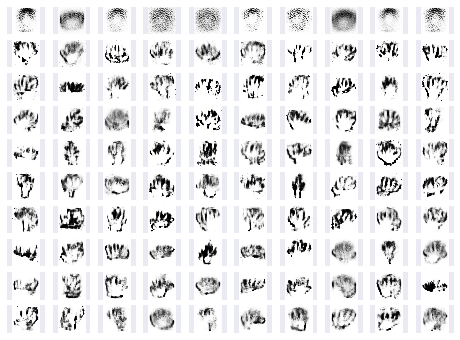

In [52]:
rows, cols = 10, 10
fig, axes = plt.subplots(figsize=(8,6), nrows=rows, ncols=cols, sharex=True, sharey=True)

for sample, ax_row in zip(samples[::int(len(samples)/rows)], axes):
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        ax.imshow(img.reshape((28,28)), cmap='Greys')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)